In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import os
import folium
import requests
import json
import urllib
from IPython.display import Image
from src.visualization.spain_energy_grid_visualisation import *
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['axes.titlesize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['lines.linewidth'] = 2


# About the dataset:
The datasets contains 4 years of electrical consumption, generation, pricing, and weather data for Spain (from 2015 to 2019). The dataset has been sourced from the work performed by [Nicholas Jhana](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather)

In [2]:
energy_df = pd.read_csv('data/raw/energy_dataset.csv')  # Read in datasets
weather_df = pd.read_csv('data/raw/weather_features.csv')


The demand curve within the power-sector is perfectly inelastic (vertical); the price of *energy demand* does not vary with the quantity demanded, since whatever is demanded at a given time has to be instantly served, regardless of price.

The supply curve however is positively sloping and energy generation is a highly competitive market with lots of different players as the demand changes the supplied price increases.

The net effect of the supply and demand curve is a pricing that is highly dependent on the load since at high loads more expensive sources of generation will come online. 

The figure below shows the price for two different loads on the system (image taken from [HERE](https://www.e-education.psu.edu/ebf200/node/151))

<img src= "https://www.e-education.psu.edu/ebf200/sites/www.e-education.psu.edu.ebf200/files/generation%20stack2.jpg" alt ="Energy Demand" style='width: 600px;'>

Text(0, 0.5, 'Normalized Value')

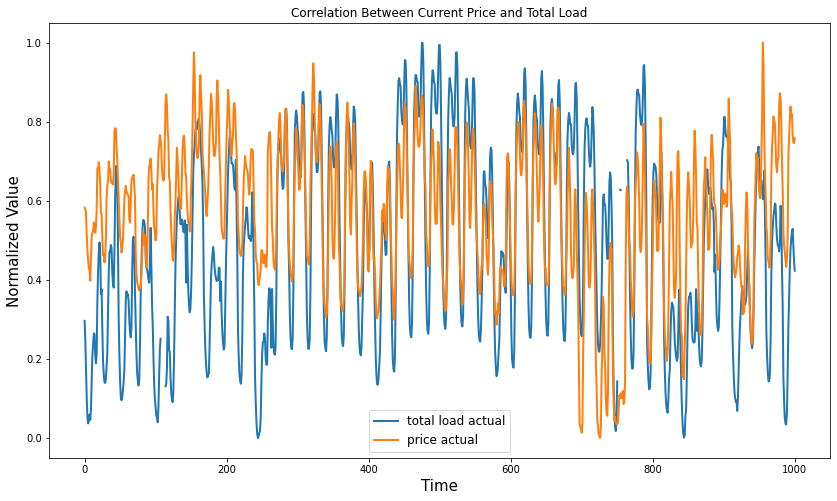

In [9]:
def scale_column(col):
    return (col - col.min())/(col.max()-col.min())

fig,ax = plt.subplots(figsize = (14, 8))  # The current energy price and the load are correlated
energy_df.loc[0:1000,['total load actual', 'price actual']].apply(scale_column).plot(ax=ax)
ax.set_title('Correlation Between Current Price and Total Load')
ax.set_xlabel('Time')
ax.set_ylabel('Normalized Value')


# Exploration of the Energy Dataset


In [10]:
print(energy_df.columns)
energy_df.head()

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


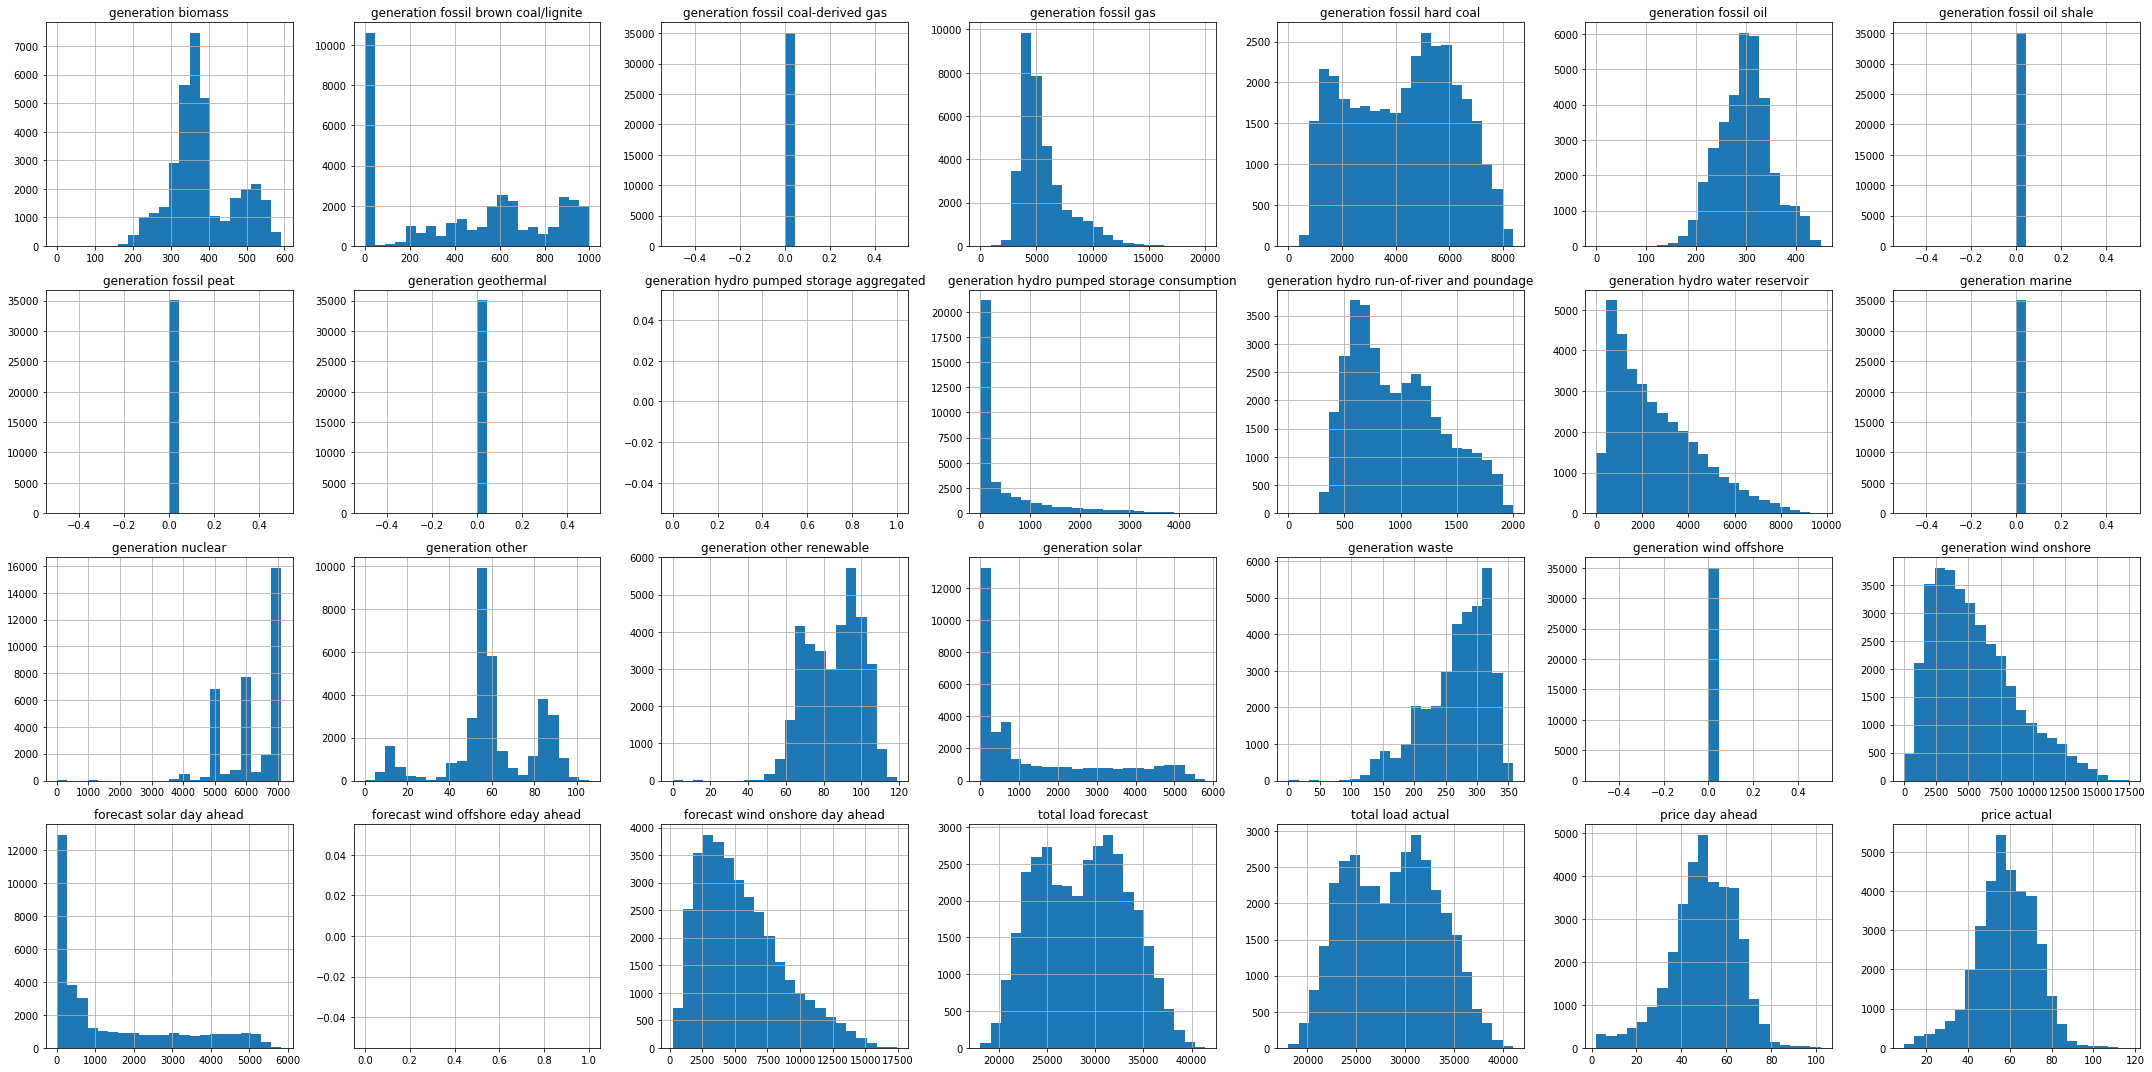

In [49]:
fig,ax = plt.subplots(4, 7, figsize=(30, 15))
axs = ax.ravel()
for i, colname in enumerate(energy_df.drop('time', axis=1).columns):
    energy_df[colname].hist(bins = 22, ax=axs[i])
    axs[i].set_title(colname, fontsize = 12)
fig.tight_layout()


Spain's energy grid lacks the following sources of energy production which can therefore be neglected:
 - fossil coal derived gas
 - fossil oil shale
 - fossil peat
 - geothermal
 - hydro pumped storage
 - marine power
 - offshore wind

It is notable that Spain has no offshore wind power but a significant amount of onshore wind power. This is likely due to the absence of a continental shelf within the bay of Biscay (shown below) preventing more traiditional ground mounted offshore wind farms to be developed. More recently efforts have been made to develop [floating offshore wind farms](https://www.maritime-executive.com/article/plans-for-spain-s-first-large-floating-offshore-wind-farm). Image below taken from [here](https://www.researchgate.net/publication/275171101_Analysis_of_the_physical_processes_controlling_the_storm_surge_during_Xynthia_February_2010).

<img src= "https://www.researchgate.net/profile/X-Bertin/publication/275171101/figure/fig1/AS:613954632044553@1523389599289/Bathymetric-map-of-the-Bay-of-Biscay-showing-the-location-of-the-tide-gages-of-Sables.png" alt ="Energy Demand" style='width: 300px;'>


These columns can be removed from the dataset

In [11]:
def drop_absent_cols(df):
    df = df.fillna(0)
    drop_col_list = []
    for col in df.columns:
        if all(df[col]==0.0):  # If all values are 0
            drop_col_list.append(col)
            print('dropping column: ', col)
    df = df.drop(drop_col_list, axis=1)
    return df

energy_df = drop_absent_cols(energy_df)

dropping column:  generation fossil coal-derived gas
dropping column:  generation fossil oil shale
dropping column:  generation fossil peat
dropping column:  generation geothermal
dropping column:  generation hydro pumped storage aggregated
dropping column:  generation marine
dropping column:  generation wind offshore
dropping column:  forecast wind offshore eday ahead


Begin by converting the time index to a datetime index

In [12]:
def datetime_conversion(df):
    df.index = pd.to_datetime(df.time, utc= True)
    df = df.drop('time', axis=1)
    return df
energy_df = datetime_conversion(energy_df)

## Breakdown by sector
Categorize energy sources into renewable sources, fossil fuels and other

In [3]:
renewable_sources = ['solar', 'wind onshore', 'other renewable', 'hydro pumped storage consumption', 'hydro run-of-river and poundage', 'hydro water reservoir']
renewable_cols = ['generation ' + source for source in renewable_sources]
fossil_fuel_sources = ['fossil brown coal/lignite', 'fossil gas', 'fossil hard coal', 'fossil oil']
fossil_fuel_cols = ['generation ' + source for source in fossil_fuel_sources]
other_source = ['nuclear', 'other', 'waste', 'biomass']
other_cols = ['generation ' + source for source in other_source]

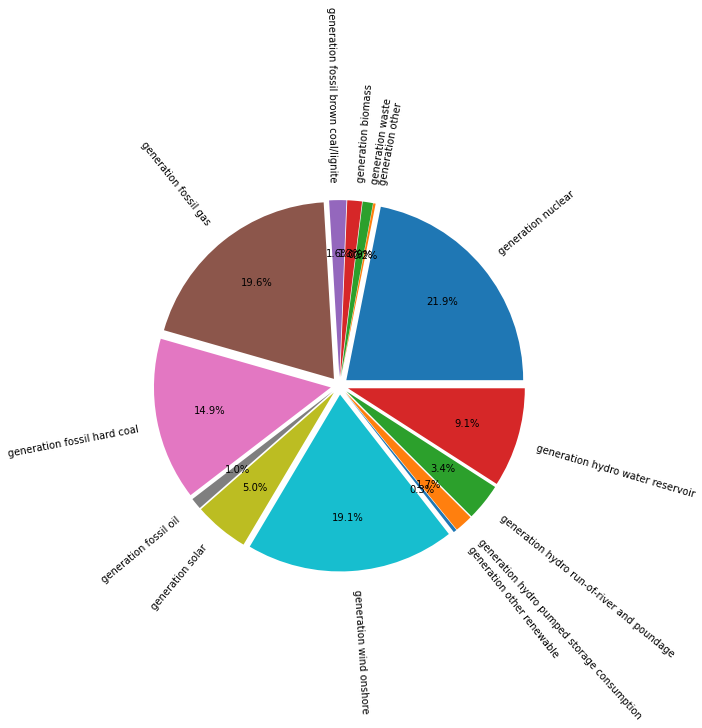

In [14]:
fig,ax = plt.subplots(figsize = (15,10))
energy_df[other_cols + fossil_fuel_cols + renewable_cols].mean().plot.pie(ax = ax, explode=[0.05]*14, pctdistance=0.7, autopct="%.1f%%", rotatelabels = 0.1)
ax.set_ylabel('')
fig.tight_layout()

Key takeaways from the breakdown of Spain's energy grid:
 - Renewables account for around 40% of the energy grid
 - Onshore Wind is the largest source of renewable energy generation by a large margin (in fact 5th highest in the world in terms of installed power)
 - Significant production from nuclear and gas

## Exploring Trends Over Time 

Text(0.5, 1.0, 'Energy Generation By Source (MW)')

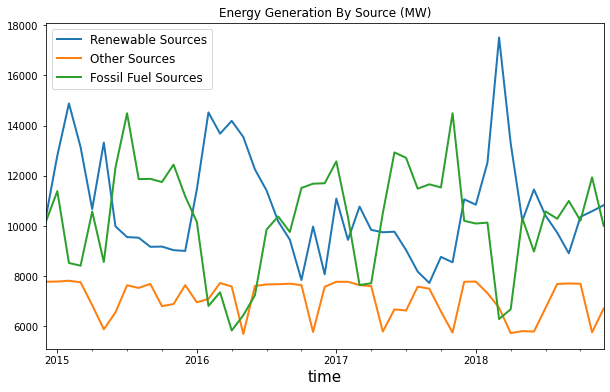

In [15]:
fig, ax = plt.subplots(figsize = (10,6))
labels = ['Renewable Sources','Other Sources', 'Fossil Fuel Sources']
for i, source_type in enumerate([renewable_cols, other_cols, fossil_fuel_cols]):
    energy_df[source_type].sum(axis=1).resample('1m').median().plot(ax=ax, label = labels[i])
ax.legend()
ax.set_title('Energy Generation By Source (MW)')


Some interesting trends are shown here:
 - When renewable energy production peaks, production from fossil fuels tends to drop. This is likely due to renewable energy sources handling most of the demand so grid operators can take the fossil fuel sources offline
 - Renewable energy sources peak during late winter - spring. Given the penetration of wind power, it is likely that this peak is due to high winds during winter. This will be confirmed through analysis of the weather dataset
 - No overall trend exists -> from 2015-2019 it seems as though not much has been done in terms of increasing renewable penetration

Trends in renewable generation

Text(0, 0.5, 'Power Generation (MW)')

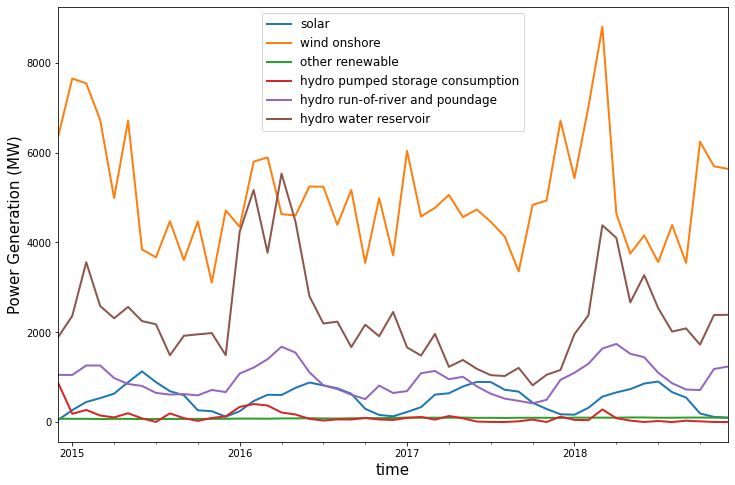

In [31]:
fig,ax = plt.subplots(figsize = (12,8))
for i, col in enumerate(renewable_cols):
     energy_df[col].resample('1m').median().plot(ax=ax, label = renewable_sources[i])
ax.legend()
ax.set_ylabel('Power Generation (MW)')

Again there is no overall trend, little wind solar or hydro was added over the years 2015 - 2019.
Some additional remarks are:
 - solar has a much smoother profile, following a sinusoidal curve, peaking in summer while wind and water reservoir have a much more errativ profile
   - wind is more erratic and less predictable than solar. The erratic nature of the water reservoir profile is more confusing but its profile seems to follow closely with the wind production profile
  
  

# Exploring the weather dataset

The focus on this project will be about the ability to predict the energy generation of renewables. Fossil fuel based generation is largely dependent on renewable based generation as demonstrated above. Therefore the ability to predict renewable energy generation is important for grid system operators.

The maajor sources that I will focus on are 
 - Onshore Wind Production
 - Hydro water reservoir
 - Solar Production

I will first use the pre-existing weather data to create a benchmark model then use an API to build upon the model

In [4]:
print(weather_df.columns)
weather_df.head()

Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


The weather dataset contains information from five different cities around the country
 - Barcelona - in the north-east
 - Bilbao - in the north 
 - Madrid - in the centre
 - Seville - in the south-west
 - Valencia - in the east

<img src= "http://www.railpass.com/sites/default/files/2016-06/SPAIN.jpg" alt ="Energy Demand" style='width: 300px;'>

The weather data is fairly limited spatially and unfortunately does not include any locations in the North-West of the country which receives significant wind.

## Wind production

The following graph shows the regional distribution of wind generation through the autonomous communities (CCAA) of spain. The following years can be accessed by changing 'year':

 - 2008
 - 2009
 - 2010
 - 2015
 
Based on 2015 data, castilla-leon is a clear front-runner in terms of production, followed by castilla-la-mancha.
Interestingly the northern CCAAs produce very wind power, this is likely due to lack of rolling plains (very mountaineous)

In [4]:
geo_json_path = r'.\data\external\spain-regions.geojson'
map_regional_data(geo_json_path, get_ccaa_wind_data(), year='2015')

# Solar Production:
The following map shows the solar production in each region for 2011, while this is very outdated (compared with the 2015-2019 dataset), between 2011 to 2018 very little changed in Spain in the addition of solar as shown below, hence it is safe to assume that the regional trends stayed roughly the same.
Image taken from [wikipedia](https://en.wikipedia.org/wiki/Solar_power_in_Spain)


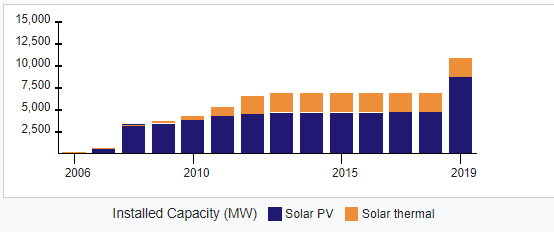

In [9]:
Image(filename=r'reports\figures\spain-installed-solar.png') 


In [6]:
map_regional_data(geo_json_path, 
                  get_ccaa_solar_data(), 
                  year='2011', 
                  gen_type='solar')

It is clear that the southern CCAAs produce far more solar generation than the northern regions, Andalucia and Castilla La mancha both have an installed capacity of around 900 MW

# Hydropower generation

As shown above, Spain has three sources of hydropower:
 - water reservoirs
 - run-of-river and poundage
 - pumped hydro

In [17]:
weather_df.groupby('city_name').mean()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283
